# Machine Learning

## TME 01 - Arbres de décision, sélection de modèles

**Ben KABONGO**, M1 DAC, Sorbonne Université, 2022-2023

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree, metrics, model_selection

plt.style.use('seaborn-whitegrid')

## I.  L’essentiel sur les arbres de décision

Un arbre de décision est un modèle de classification hiérarchique.

Pour des exemples sous la représentation $x = (x_1, x_2, . . . , x_d) ∈ R^d$, à chaque nœud de l’arbre est associé un test sur une des dimensions $x_i$ de la forme $x_i \le s$ avec $s$ une valeur réelle. Ce test indique le nœud fils qui doit être sélectionné (par exemple pour un arbre binaire, le fils gauche quand le test est vrai, le fils droit sinon).

À chaque feuille de l’arbre est associée une étiquette. Ainsi, la classification d’un exemple consiste en une succession de tests sur les valeurs des dimensions de l’exemple, selon un chemin dans l’arbre de la racine à une des feuilles. La feuille atteinte donne la classe prédite.

L’apprentissage de l’arbre s’effectue de manière récursive gloutonne top-down : à chaque nœud, l’algorithme doit choisir un test optimal, c’est-à-dire à la fois sur quelle dimension faire le test et quel seuillage appliqué (ce qu’on appelle un split). 

La mesure d’optimalité est en général une mesure d’homogénéité sur la partition obtenue, usuellement l’entropie de Shanon ou l’index de Gini. L’entropie d’une partition est d’autant plus petite qu’une classe prédomine dans chaque sous-ensemble de la partition, elle est nulle lorsque la séparation est parfaite (un seul label présent dans chacune des partitions) et maximale lorsque l’ensemble est le plus désordonné possible (équiprobabilité des labels dans chaque partition).

Pour calculer le split optimal, chaque dimension de l’espace de description est considérée itérativement ; pour une dimension $i$, les exemples sont triés par rapport à la valeur de l’attribut de cette dimension $x_i$, puis pour chaque split possible, le calcul de l’homogénéité des deux partitions obtenues (en termes de label) par ce split est effectué. Le split ayant la meilleure homogénéité est alors choisi.

Bien que l’algorithme pourrait continuer récursivement jusqu’à n’obtenir que des feuilles contenant un ensemble pur d’exemples (d’une seule classe), on utilise souvent des critères d’arrêts (pourquoi ? - nous y reviendrons lors de ce TP). Les plus utilisés sont le nombre d’exemples minimum que doit contenir un nœud pour être divisé (critère local) et la profondeur maximale de l’arbre (critère global).


### Entropie

Le but de cet exercice est d’implémenter les fonctions utiles au calcul du partitionnement optimal, i.e. les fonctions de calcul d’entropie. 

_Ne passer pas trop de temps sur cette partie! Passer si vous n’y arrivez pas. Il n’est pas nécessaire de coder ces fonctions pour la suite du TME._

Soit un objet itérable $vect$ (une liste ou un vecteur numpy par exemple) qui contient une liste de label. Coder une fonction **entropie(vect)** qui calcule l’entropie de ce vecteur : $$H(Y) = −\sum_{y \in Y} p_ylog(p_y)$$ $p_y$ correspond à la probabilité du label $y$ dans le vecteur vect. 

_Penser à utiliser l’objet Counter du module collections qui permet de faire un histogramme des éléments d’une liste._

In [2]:
def entropy(vect):
    y, c = np.unique(vect, return_counts=True)
    py = c / c.sum()
    return -(py * np.log(py)).sum()

In [3]:
entropy([1, 1, 2, 2])

0.6931471805599453

L’entropie conditionnelle permet de calculer l’homogénéité de la partition obtenue. Dans le cas général d’un split n-aire en $n$ partitions $P = \{P_1, . . . , P_n\}$, l’entropie conditionnelle à P s’écrit $$H(Y|P)= \sum_i p(P_i) H(Y|P_i)$$ avec $$H(Y|P_i)=- \sum_{y \in Y} p(y|P_i)log(p(y|P_i))$$ l’entropie des labels conditionnée à la partition considérée et $$p(P_i) = \frac{|P_i|}{\sum_j |P_j|}$$ la proportion d’éléments dans $P_i$. Il s’agit en fait de la moyenne pondérée des entropies des sous-ensembles obtenus.

Coder la fonction **entropie_cond(list_vect)** qui à partir d’une liste de listes de labels (la partition des labels), calcule l’entropie conditionnelle de la partition.

In [4]:
def entropie_cond(list_vect):
    ppi = np.array([len(vect) for vect in list_vect])
    ppi = ppi / ppi.sum()
    hypi = np.array([entropy(vect) for vect in list_vect])
    return (ppi * hypi).sum()

Le code suivant permet de charger un extrait de la base imdb (à télécharger sur le site de l’ue).

Chaque ligne du tableau data correspond à la description d’un film (le titre dans id2titles, chaque colonne à un attribut (dont la signification est donnée par fields). 

La plupart sont des genres (action, comédie, ...), la valeur 1 indique l’appartenance du film au genre, 0 sinon. Les dernières colonnes concernent l’année de production, la durée du film, le budget, le nombre de vote et la note moyenne attribuée au film. On binarise la note moyenne afin d’avoir deux classes, les films de note supérieure à 6.5, et les autres (vecteur datay).

In [5]:
import pickle
import numpy as np
# data : tableau (films ,features), id2titles : dictionnaire id -> titre , # fields : id feature -> nom
[data, id2titles, fields] = pickle.load(open("imdb_extrait.pkl","rb"))
# la derniere colonne est le vote
datax = data[:,:32]
datay = np.array([1 if x[33]>6.5 else -1 for x in data])

In [6]:
print(datax.shape)
print(datax[:2])

(4587, 32)
[[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0800e+02 2.0000e+00
  1.9880e+03 1.2324e+07]
 [0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 9.5000e+01 2.0000e+00
  2.0090e+03 7.5000e+06]]


In [7]:
print(len(id2titles))
for k, v in tuple(id2titles.items())[:5]:
    print(k, '\t:', v)

4587
0 	: 'Crocodile' Dundee II
1 	: (500) Days of Summer
2 	: ...E tu vivrai nel terrore! L'aldilà
3 	: 10 Things I Hate About You
4 	: 10,000 BC


In [8]:
fields

{0: 'Sci-Fi',
 1: 'Crime',
 2: 'Romance',
 3: 'Animation',
 4: 'Music',
 5: 'Comedy',
 6: 'War',
 7: 'Horror',
 8: 'Film-Noir',
 9: 'Adult',
 10: 'News',
 11: 'Reality-TV',
 12: 'Thriller',
 13: 'Western',
 14: 'Mystery',
 15: 'Short',
 16: 'Talk-Show',
 17: 'Drama',
 18: 'Action',
 19: 'Documentary',
 20: 'Musical',
 21: 'History',
 22: 'Family',
 23: 'Adventure',
 24: 'Fantasy',
 25: 'Game-Show',
 26: 'Sport',
 27: 'Biography',
 28: 'Duree',
 29: 'couleur',
 30: 'annee',
 31: 'budget',
 32: 'nb_votes',
 33: 'rating'}

Calculer pour chaque attribut binaire l’entropie et l’entropie conditionnelle du vote selon la partition induite par l’attribut (les exemples dont la valeur de l’attribut est 1 vs les autres). Calculer également la différence entre l’entropie et l’entropie conditionnelle pour chaque attribut. A quoi correspond une valeur de 0 ? une valeur de 1 ? Quel est le meilleur attribut pour la première partition ?

In [9]:
n = 28
entropies = np.zeros(n)
entropies_cond = np.zeros(n)
for i in range(n):
    entropies[i] = entropy(datax[:, i])
    idxi0 = np.where(datax[:, i] == 0)[0]
    idxi1 = np.where(datax[:, i] == 1)[0]
    entropies_cond[i] = entropie_cond([datay[idxi0], datay[idxi1]])
diff_entropies = entropies - entropies_cond

`Lorsque la différence entre l'entropie et l'entropie conditionnelle est égale à 0, cela signifie que la connaissance de l'attribut n'apporte aucune information supplémentaire pour prédire la classe des exemples. Lorsque la différence est égale à 1, cela signifie que l'attribut permet de prédire parfaitement la classe des exemples.`

`Le meilleur attribut pour la première partition est celui qui a la plus grande différence entre l'entropie et l'entropie conditionnelle, c'est-à-dire celui qui a le plus grand gain d'information.Le meilleur attribut pour la première partition est celui qui a la plus grande différence entre l'entropie et l'entropie conditionnelle, c'est-à-dire celui qui a le plus grand gain d'information.`

In [10]:
idx_sort = diff_entropies.argsort()[::-1]
idx_sort, diff_entropies[17]

(array([17,  5, 12, 18,  2,  1, 23,  0,  7, 24, 14, 22, 27,  6,  3, 21, 26,
         4, 20, 13, 19,  8, 15, 16, 11, 10,  9, 25]),
 0.051064687580500645)

In [11]:
fields[17]

'Drama'

## II. Quelques expériences préliminaires

Nous utiliserons les conventions de **scikit-learn** dans la suite : les modèles d’apprentissage sont munis :
- d’un constructeur (qui permet d’initialiser les paramètres, variables d’instance de l’objet)
- d’une méthode **fit(data,labels)** qui permet d’apprendre le modèle sur les données en paramètre
- d’une méthode **predict(data)** qui permet d’obtenir un vecteur de prédiction pour les données passées en paramètre 
- d’une méthode **score(data,labels)** qui permet de renvoyer le pourcentage de bonne classification des données par rapport aux labels passés en paramètre.

Le code suivant permet de créer, d’apprendre un arbre de décision et de l’utiliser :

In [12]:
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
import pydotplus

id2genre = [x[1] for x in sorted(fields.items())[:-2]]
dt = DecisionTreeClassifier()
dt.max_depth = 5 #on fixe la taille max de l’arbre a 5 
dt.min_samples_split = 2 #nombre minimum d’exemples pour spliter un noeud 
dt.fit(datax ,datay)
dt.predict(datax[:5,:])
print(dt.score(datax,datay))

# utiliser http://www.webgraphviz.com/ par exemple ou https://dreampuf.github.io/Graphviz export_graphviz(dt, out_file="/tmp/tree.dot",feature_names=id2genre)
# ou avec pydotplus
tdot = export_graphviz(dt,feature_names=id2genre)
pydotplus.graph_from_dot_data(tdot).write_pdf('tree.pdf')

0.736647045999564


True

Sur la base de données imdb, apprendre quelques arbres de profondeurs différentes. Visualiser-les. Que remarquez-vous quant au nombre d’exemples séparés à chaque niveau en fonction de la profondeur ? est-ce normal ?

Calculer les scores de bonne classification. Comment ils évoluent en fonction de la profondeur ? Est-ce normal ?
`Le score de bonne classification en entrainement augmentent avec la profondeur maximale de l'arbre de décision. Cela est tout à fait compréhensible : plus la profondeur augmente, plus l'arbre est capable de correctemet repartir les données d'apprentissage. Il est alors nécessaire de tester l'arbre appris sur des données de test afin d'être sûr que l'on ne surapprend pas.`

Ces scores sont-ils un indicateur fiable du comportement de l’algorithme ? Comment obtenir un indicateur plus fiable ? `Les scores obtenus en entrainement ne sont pas complètement fiables. Un score en entrainement très bas dénote d'un sous-apprentissage du modèle. Cependant, un score élevé n'est pas forcément indicateur d'un excellent modèle. En effet, il est nécessaire d'avoir des données de test sur lesquelles éprouver le modèle appris en entraînement. Un score haut en apprentissage et faible en test dénote ainsi d'un sur-apprentissage. Un modèle acceptable présente un bon score en apprentissage et un bon score en test.`

In [13]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    datax, datay, test_size=0.3, random_state=42
)
print('Train shape :', X_train.shape)
print('Test shape :', X_test.shape)

Train shape : (3210, 32)
Test shape : (1377, 32)


In [14]:
for depth in range(2,11):
    model = DecisionTreeClassifier(max_depth=depth)
    model.fit(X_train, y_train)
    print('-----------------------------------------------')
    print('depth =', depth)
    print('Train accuracy =', model.score(X_train, y_train))
    print('Test accuracy =', model.score(X_test, y_test))
    # pydot  
    tdot = export_graphviz(model,feature_names=id2genre)
    pydotplus.graph_from_dot_data(tdot).write_pdf(f'tree_depth_{depth}.pdf')

-----------------------------------------------
depth = 2
Train accuracy = 0.6825545171339564
Test accuracy = 0.6862745098039216
-----------------------------------------------
depth = 3
Train accuracy = 0.7168224299065421
Test accuracy = 0.7138707334785767
-----------------------------------------------
depth = 4
Train accuracy = 0.7314641744548287
Test accuracy = 0.7320261437908496
-----------------------------------------------
depth = 5
Train accuracy = 0.7423676012461059
Test accuracy = 0.7342047930283224
-----------------------------------------------
depth = 6
Train accuracy = 0.7576323987538941
Test accuracy = 0.7240377632534495
-----------------------------------------------
depth = 7
Train accuracy = 0.7728971962616823
Test accuracy = 0.7247639796659404
-----------------------------------------------
depth = 8
Train accuracy = 0.7912772585669782
Test accuracy = 0.7269426289034132
-----------------------------------------------
depth = 9
Train accuracy = 0.8137071651090343
Tes

## III. Sur et sous apprentissage

Pour obtenir une meilleure estimation de l’erreur du classifieur appris, il est usuel d’utiliser deux ensembles d’exemples étiquetés :
- l’ensemble d’apprentissage : l’apprentissage du classifieur ne se fait que sur ce sous-ensemble d’exemples ;
- l’ensemble de test : cet ensemble sert à évaluer l’erreur du classifieur.

Ces deux sous-ensembles sont tirés de manière aléatoire en faisant une partition en 2 parties des exemples disponibles. L’erreur faîte sur l’ensemble d’apprentissage s’appelle l’erreur d’apprentissage, celle sur l’ensemble de test l’erreur de test.

Pour différents partitionnement, par exemple des partages en $(0.2,0.8),(0.5,0.5),(0.8,0.2)$, tracer les courbes de l’erreur en apprentissage et de l’erreur en test en fonction de la profondeur du modèle.

In [15]:
sizes = [.2, .5, .8]
depths = [2, 4, 5, 8, 10, 15, 20, 30]

scores = np.zeros((len(sizes), len(depths), 2))

for s, size in enumerate(sizes):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        datax, datay, test_size=size, random_state=42
    )
    
    for d, depth in enumerate(depths):
        model = DecisionTreeClassifier(max_depth=depth)
        model.fit(X_train, y_train)
        scores[s, d, 0] = 1 - model.score(X_train, y_train)
        scores[s, d, 1] = 1 - model.score(X_test, y_test)
        
print(scores)

[[[0.31425457 0.32570806]
  [0.25838103 0.2962963 ]
  [0.25020442 0.2788671 ]
  [0.19351322 0.28213508]
  [0.14091033 0.291939  ]
  [0.04006541 0.32135076]
  [0.00572363 0.32352941]
  [0.         0.32570806]]

 [[0.31007414 0.32258065]
  [0.27213258 0.26809067]
  [0.25381596 0.29555362]
  [0.16921064 0.31560593]
  [0.11251635 0.31255449]
  [0.03445268 0.34263296]
  [0.0043611  0.34176112]
  [0.         0.34306888]]

 [[0.29225736 0.30681199]
  [0.25736096 0.26920981]
  [0.22246456 0.28283379]
  [0.13631407 0.3013624 ]
  [0.09051254 0.32125341]
  [0.00327154 0.34250681]
  [0.         0.33950954]
  [0.         0.33188011]]]


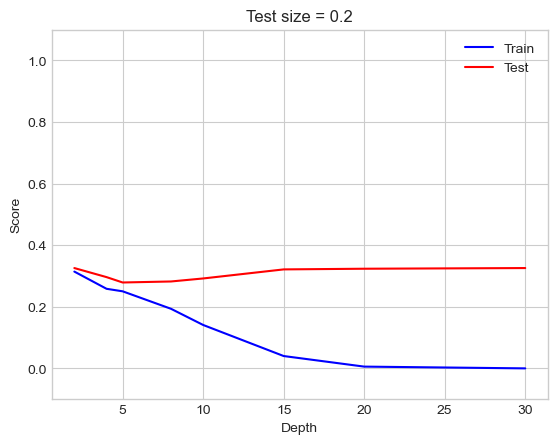

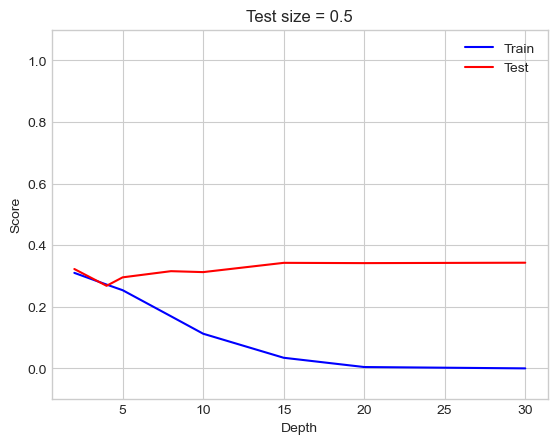

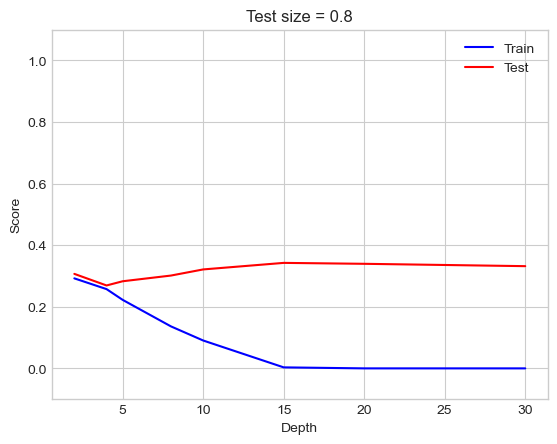

In [16]:
for s, size in enumerate(sizes):
    plt.figure()
    plt.title(f'Test size = {size}')
    plt.plot(depths, scores[s, :, 0], c='b', label='Train')
    plt.plot(depths, scores[s, :, 1], c='r', label='Test')
    plt.xlabel('Depth')
    plt.ylabel('Score')
    #plt.xticks(depths)
    plt.ylim(-0.1, 1.1)
    plt.legend()
    plt.show()

Que remarquez vous quand il y a peu d’exemples d’apprentissage ? Comment progresse l’erreur ? De même quand il y a beaucoup d’exemples d’apprentissage. Est-ce le même comportement pour les deux erreurs ?

`En apprentissage, plus il y a peu de données, plus un arbre qui donne des bonnes prédictions en apprentissage est vite appris pour des profondeurs de plus en plus petites. Il y a une correlation entre la taille des données d'apprentissage, le nombre de features et la profondeur de l'arbre que l'on veut obtenir.`
`Quand le nombre d'exemples augmente, l'erreur est apprentissage est grand pour des petites profondeurs`

Vos résultats vous semblent ils fiables et stables ? Comment les améliorer ?

`Pas forcément fiables ou stables : en effet, il y a beaucoup d'aléatoire sur la façon de split les données test/train. Cet aléa peut ainsi favoriser les résultats de certains arbres plutôt que d'autres. Nécessité de contourner l'aléa.`

## IV. Validation croisée : sélection de modèle

Il est rare de disposer en pratique d’un ensemble de test (on préfère inclure le plus grand nombre de données dans l’ensemble d’apprentissage). Pour sélectionner un modèle tout en considérant le plus grand nombre d’exemples possible pour l’apprentissage, on utilise généralement une procédure dite de sélection par validation croisée. Pour chaque paramétrisation de l’algorithme, une estimation de l’erreur empirique du classifieur appris est faîte selon la procédure suivante :

- l’ensemble d’apprentissage $E_{app}$ est partitionné en $n$ ensembles d’apprentissage \{$E_i$\};
- Pour $i = 1..n$
    * l’arbre est appris sur $E_{app}$\$E_i$
    
    * l’erreur en test $err(E_i)$ est évaluée sur $E_i$ (qui n’a pas servi à l’apprentissage à cette itération)
    * l’erreur moyenne $err = \frac{1}{n} \sum_{i=1}^{n} err(E_i)$ est calculée, le modèle sélectionné est celui qui
minimise cette erreur

Refaire les expériences précédentes avec cette fois de la validation croisée (soit faîte à la main, soit en utilisant les fonctions de scikit-learn). Vous pouvez également étudier les autres hyper-paramètres du modèle (nombre minimal d’exemples par nœud, gain d’entropie minimal . . . )

In [17]:
model = DecisionTreeClassifier()
param_grid = {'max_depth': np.arange(1, 11), 'min_samples_leaf': np.arange(1, 11)}

grid_search = model_selection.GridSearchCV(model, param_grid, cv=5)
grid_search.fit(datax, datay)

print('Paramètres optimaux :', grid_search.best_params_)
print('Score :', grid_search.best_score_)

Paramètres optimaux : {'max_depth': 6, 'min_samples_leaf': 8}
Score : 0.7257467872645241
